pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-11-18 10:23:39.994119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731925420.006733    1579 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731925420.010714    1579 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:23:40.024581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
error: XDG_RUNTIME_DIR not set in the environment.


Starting the training for multiple visibility frequencies
Running for visibility frequency (vf): 0.1


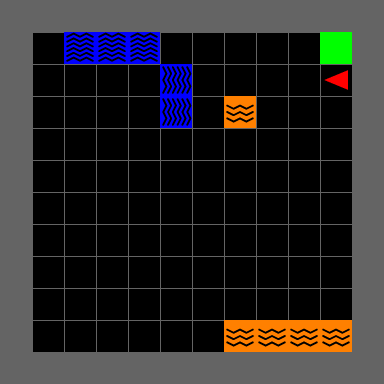

Shield unable to view environment, returning default action mask.
Shield unable to view environment, returning default action mask.


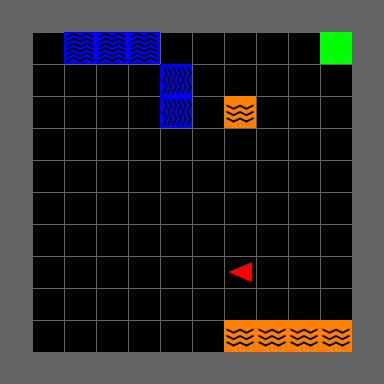

The shield for shield_value = 0.1
Visibility Frequency: 0.1
Shield unable to view environment, returning default action mask.
Training with shield:
Shield unable to view environment, returning default action mask.


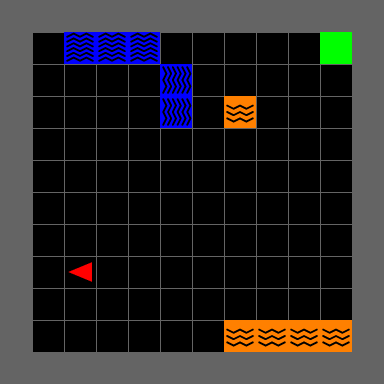

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Training for vf = 0.1
-----------------------------------
| info/                |          |
|    no_shield_action  | 2048     |
|    sum_opened_door   | 0        |
|    sum_picked_up     | 0        |
|    sum_ran_into_lava | 8        |
|    sum_reached_goal  | 1        |
| rollout/             |          |
|    ep_len_mean       | 142      |
|    ep_rew_mean       | -0.5     |
| time/                |          |
|    fps               | 384      |
|    iterations        | 1        |
|    time_elapsed      | 5        |
|    total_timesteps   | 2048     |
-----------------------------------
-------------------------------------------
| info/                   |               |
|    no_shield_action     | 4096          |
|    sum_opened_door      | 0             |
|    sum_picked_up        | 0             |
|    sum_ran_into_lava    | 14            |
|  

In [1]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat

import gymnasium as gym

from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import tempfile, datetime, shutil

import time
import os

from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image,create_episode_animation
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, ImageRecorderCallback, InfoCallback

import os, sys
from copy import deepcopy

from PIL import Image

import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.animation as animation


os.environ['M2P_BINARY'] = '/opt/Minigrid2PRISM/build/main'
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")
import gymnasium as gym
import random


def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7
    
def main():
    # Edit 'environments/Minigrid/minigrid/envs/Playground.py' to alter the environment
    env_name = "MiniGrid-Playground-v0"

    # TODO Change the safety specification
    formula = "Pmax=? [G !AgentIsOnLava]"
    shield_comparison = "absolute"
    shielding = ShieldingConfig.Training

    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])

    # Visibility frequencies to iterate over
    visibility_frequencies = [0.1]

    for vf in visibility_frequencies:
        print(f"Running for visibility frequency (vf): {vf}")
        value_for_training = vf

        # Initialize environment
        env = gym.make(env_name, render_mode="rgb_array")
        image_env = RGBImgObsWrapper(env, TILE_PIXELS)
        env = RGBImgObsWrapper(env, 8)
        env = ImgObsWrapper(env)
        env = MiniWrapper(env)

        env.reset()
        Image.fromarray(env.render()).show()

        shield_handlers = dict()
        if shield_needed(shielding):
            for value in [vf]:
                shield_handler = MiniGridShieldHandler(
                    GRID_TO_PRISM_BINARY,
                    "grid.txt",
                    "grid.prism",
                    formula,
                    shield_value=value,
                    shield_comparison=shield_comparison,
                    nocleanup=True,
                    prism_file=None,
                    visibility_frequency=value
                )
                env = MiniGridSbShieldingWrapper(
                    env, shield_handler=shield_handler, create_shield_at_reset=False
                )
                create_shield_overlay_image(image_env, shield_handler.create_shield())
                print(f"The shield for shield_value = {value}")

                shield_handlers[value] = shield_handler

        print("Visibility Frequency:", vf)
        if shielding == ShieldingConfig.Training:
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
            env = ActionMasker(env, mask_fn)
            print("Training with shield:")
            create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
        elif shielding == ShieldingConfig.Disabled:
            env = ActionMasker(env, nomask_fn)
        else:
            assert False

        model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
        model.set_logger(logger)
        steps = 20_000

        print(f"Training for vf = {vf}")
        
        callback = InfoCallback()
        #model.learn(total_timesteps=10000, callback=callback)
        model.learn(steps, callback=callback)
        
        print(f"Completed training for vf = {vf}")
        # Plot the metrics
        for metric, values in callback.metrics.items():
            plt.plot(values, label=metric)
        
        plt.title("Training Metrics")
        plt.xlabel("Steps")
        plt.ylabel("Cumulative Counts")
        plt.legend()
        plt.show()

        # Cleanup environment after training
        env.close()


if __name__ == '__main__':
    print("Starting the training for multiple visibility frequencies")
    main()
